# Adam

Adam是一个结合了**momentum**和**RMSProp**的优化算法:
- **momentum**增加了梯度动量的概念.
- **RMSProp**对学习率进行了改进,分母增加了$s$, 还增加了移动平均权重 $\rho$的概念.

$$
v = \beta_1 v + (1 - \beta_1) g      \space\space\space\space\space\space\space\space(1)   \\    
s = \beta_2 s + (1 - \beta_2) g^2     \space\space\space\space\space\space\space\space(2)
$$

$v$ 是梯度的累加, $s$ 是梯度平方的累加.

在 adam 算法里，为了减轻 v 和 s 被初始化为 0 的初期对计算指数加权移动平均的影响，每次 v 和 s 都做下面的修正, $t$是指数.

$$
\hat{v} = \frac{v}{1 - \beta_1^t}     \space\space\space\space\space\space\space\space(3)  \\
\hat{s} = \frac{s}{1 - \beta_2^t}     \space\space\space\space\space\space\space\space(4)
$$

这里 t 是迭代次数，可以看到，当 $0 \leq \beta_1, \beta_2 \leq 1$ 的时候，迭代到后期 t 比较大，那么 $\beta_1^t$ 和 $\beta_2^t$ 就几乎为 0，就不会对 v 和 s 有任何影响了，算法作者建议$\beta_1 = 0.9$, $\beta_2 = 0.999$。

$$
g' = \frac{\eta \hat{v}}{\sqrt{\hat{s} + \epsilon}}  \space\space\space\space\space\space\space\space(5)
$$

这里 $\eta$ 是学习率，$epsilon$ 仍然是为了数值稳定性而添加的常数，最后参数更新有

$$
\theta_i = \theta_{i-1} - g'  \space\space\space\space\space\space\space\space(6)
$$

## 一. 手动实现Adam

In [8]:
def adam(parameters, vs, sqrs, lr, t, beta1=0.9, beta2=0.999):
    eps=1e-8
    for param, v, sqr in zip(parameters,vs,sqrs):
        v[:]=beta1 *v + (1-beta1)*param.grad.data #公式(1)
        sqr[:]=beta2*sqr+(1-beta1)*param.grad.data**2 #公式(2)
        
        v_hat=v/(1-beta1**t) #公式(3)
        s_hat=sqr/(1-beta2**t) #公式(4)
        param.data=param.data- lr*v_hat/torch.sqrt(s_hat+eps) #公式(5)

In [5]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

def data_tf(x):
    x=np.array(x,dtype='float32')/255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('./data', train=False, transform=data_tf, download=True)

In [14]:
#定义loss函数
criterion=nn.CrossEntropyLoss()

train_data=DataLoader(train_set, batch_size=64, shuffle=True)

net=nn.Sequential(nn.Linear(784,200),
                 nn.ReLU(),
                 nn.Linear(200,10))

sqrs=[]
vs=[]
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    vs.append(torch.zeros_like(param.data))
t=1
#开始训练
losses=[]
idx=0
start=time.time()

for e in range(5):
    train_loss=0
    for im,label in train_data:
        out=net(Variable(im))
        loss=criterion(out,Variable(label))
        
        net.zero_grad()
        loss.backward()
        
        adam(net.parameters(),vs,sqrs,1e-3,t)
        t+=1
        train_loss+=loss.item()
        if idx%30==0:
            losses.append(loss.item())
        idx+=1
    print('epoch:{},train_loss:{:.5f}'.format(e,train_loss/len(train_data)))
print('Used {:.5f}s'.format(time.time()-start))

epoch:0,train_loss:0.67149
epoch:1,train_loss:0.33829
epoch:2,train_loss:0.28926
epoch:3,train_loss:0.25524
epoch:4,train_loss:0.22780
Used 36.08968s


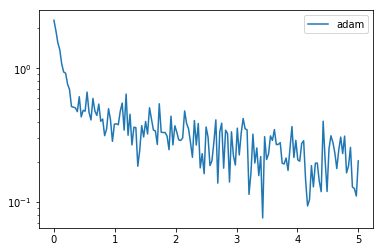

In [15]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='adam')
plt.legend(loc='best')

可以看到使用adam算法loss能够更快更好地收敛,但是一定小心学习率的设定,使用自适应的算法一般需要**更小的学习率**.

## 二. torch自带Adam-`torch.optim.Adam()`

In [16]:
train_data=DataLoader(train_set,batch_size=64,shuffle=True)
net=nn.Sequential(nn.Linear(784,200),
                 nn.ReLU(),
                 nn.Linear(200,10))

optimizer=torch.optim.Adam(net.parameters(),lr=1e-3)

#开始训练
start=time.time()
for e in range(5):
    train_loss=0
    for im,label in train_data:
        im=Variable(im)
        label=Variable(label)
        out=net(im)
        loss=criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    print('epoch:{},train_loss:{:.5f}'.format(e,train_loss/len(train_data)))
end=time.time()
print('Used {:.5f}s'.format(end-start))

epoch:0,train_loss:0.35177
epoch:1,train_loss:0.16791
epoch:2,train_loss:0.12309
epoch:3,train_loss:0.09832
epoch:4,train_loss:0.08406
Used 41.37819s


![](https://raw.githubusercontent.com/cs231n/cs231n.github.io/master/assets/nn3/opt1.gif)

![](https://raw.githubusercontent.com/cs231n/cs231n.github.io/master/assets/nn3/opt2.gif)
